In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set plot style
plt.style.use('ggplot')

In [3]:
# Load data, making sure 'breast-cancer.csv' is in the same directory
df = pd.read_csv(r"C:\Users\bond9\Downloads\archive (2)\breast-cancer.csv")

# Drop unnecessary columns, ignoring errors if a column doesn't exist
df = df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore')

# Separate features (X) and target (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Encode the target variable ('M' -> 1, 'B' -> 0)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation complete.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Data preparation complete.
Training set shape: (426, 30)
Test set shape: (143, 30)


In [4]:
# --- Linear Kernel ---
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)
print("--- SVM with Linear Kernel ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_linear):.4f}")
print(classification_report(y_test, y_pred_linear, target_names=le.classes_))

# --- RBF Kernel ---
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
print("\n--- SVM with RBF Kernel (Default Parameters) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf):.4f}")
print(classification_report(y_test, y_pred_rbf, target_names=le.classes_))

--- SVM with Linear Kernel ---
Accuracy: 0.9580
              precision    recall  f1-score   support

           B       0.94      1.00      0.97        90
           M       1.00      0.89      0.94        53

    accuracy                           0.96       143
   macro avg       0.97      0.94      0.95       143
weighted avg       0.96      0.96      0.96       143


--- SVM with RBF Kernel (Default Parameters) ---
Accuracy: 0.9720
              precision    recall  f1-score   support

           B       0.96      1.00      0.98        90
           M       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



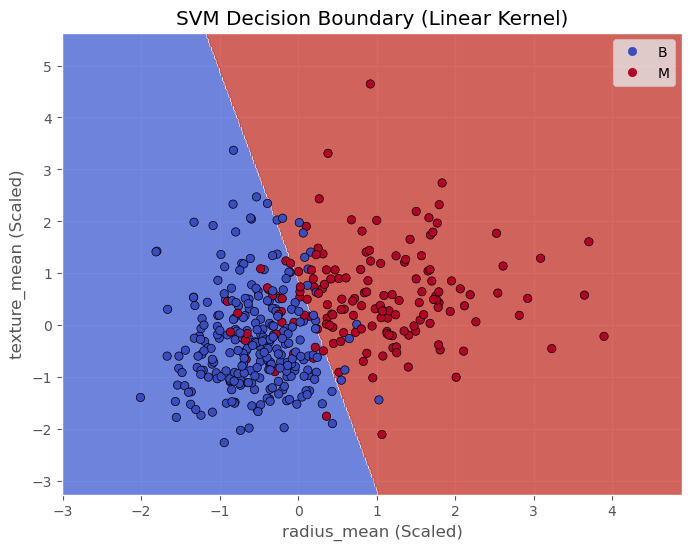

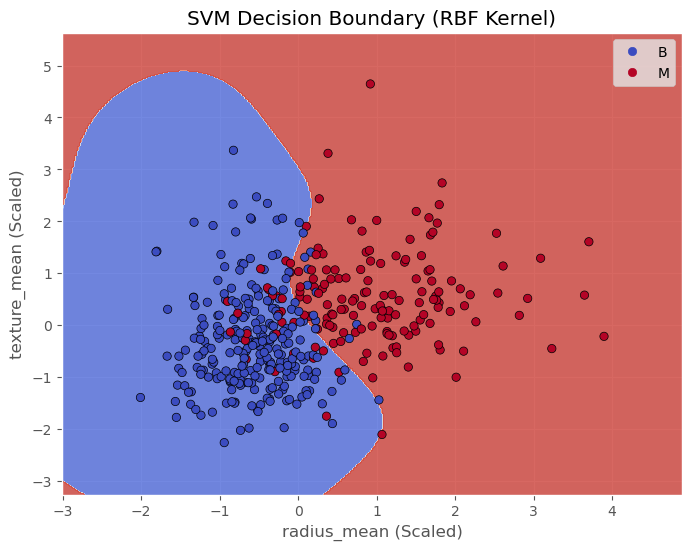

In [6]:
# Select first two features for visualization
X_train_2d = X_train_scaled[:, :2]

# Re-train models on 2D data
svm_linear_2d = SVC(kernel='linear', random_state=42).fit(X_train_2d, y_train)
svm_rbf_2d = SVC(kernel='rbf', random_state=42).fit(X_train_2d, y_train)

# Create a DataFrame from the 2D data to pass column names
X_train_2d_df = pd.DataFrame(X_train_2d, columns=[X.columns[0], X.columns[1]])


# Function to plot decision boundaries
def plot_decision_boundary(model, X_df, y, title):
    # Convert DataFrame to NumPy array for calculations
    X_arr = X_df.values
    
    h = .02  # step size in the mesh
    x_min, x_max = X_arr[:, 0].min() - 1, X_arr[:, 0].max() + 1
    y_min, y_max = X_arr[:, 1].min() - 1, X_arr[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot the training points
    scatter = plt.scatter(X_arr[:, 0], X_arr[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    # Use the column names from the passed DataFrame for labels
    plt.xlabel(f'{X_df.columns[0]} (Scaled)')
    plt.ylabel(f'{X_df.columns[1]} (Scaled)')
    plt.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_))
    plt.show()

# Plot for Linear Kernel
plot_decision_boundary(svm_linear_2d, X_train_2d_df, y_train, 'SVM Decision Boundary (Linear Kernel)')

# Plot for RBF Kernel
plot_decision_boundary(svm_rbf_2d, X_train_2d_df, y_train, 'SVM Decision Boundary (RBF Kernel)')

In [7]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Initialize GridSearchCV
# n_jobs=-1 uses all available CPU cores
grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)

# Fit the model
print("Starting GridSearchCV...")
grid.fit(X_train_scaled, y_train)

# Print the best parameters found
print("\nBest parameters found: ", grid.best_params_)
print("Best cross-validation score: {:.4f}".format(grid.best_score_))

Starting GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters found:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.9789


--- Final Tuned SVM (RBF Kernel) Performance on Test Set ---
Accuracy: 0.9790
              precision    recall  f1-score   support

           B       0.97      1.00      0.98        90
           M       1.00      0.94      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.97      0.98       143
weighted avg       0.98      0.98      0.98       143



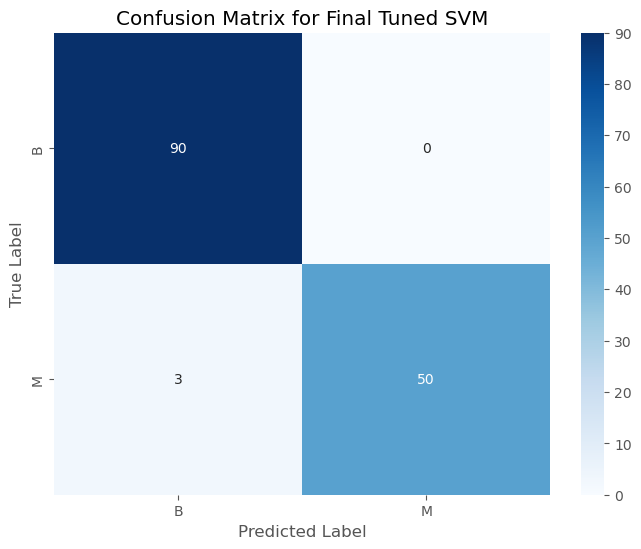

In [8]:
# Use the best estimator to make predictions
best_svm = grid.best_estimator_
y_pred_final = best_svm.predict(X_test_scaled)

print("--- Final Tuned SVM (RBF Kernel) Performance on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(classification_report(y_test, y_pred_final, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Final Tuned SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()